In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import string 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost
import eli5
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
import joblib

C:\Users\hp\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
train_df=pd.read_csv("trainmel.csv")
test_df=pd.read_csv("testmel.csv")
train_df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_df.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

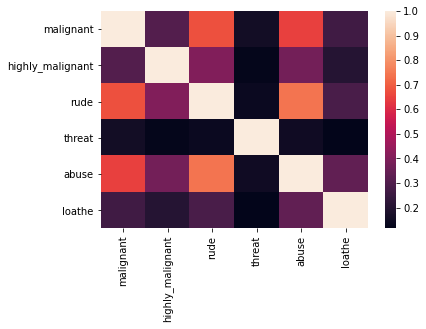

In [6]:
train_df.corr()
sns.heatmap(train_df.corr())

In [7]:
train_df.skew()

<ipython-input-7-ee6c3e8d0bd0>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_df.skew()


malignant            2.745854
highly_malignant     9.851722
rude                 3.992817
threat              18.189001
abuse                4.160540
loathe              10.515923
dtype: float64

malignant
0    144277
1     15294
Name: malignant, dtype: int64


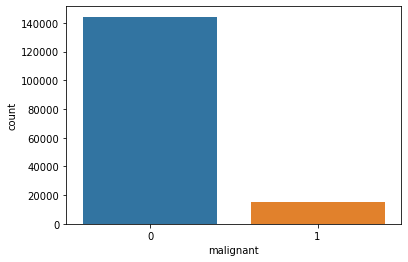

highly_malignant
0    157976
1      1595
Name: highly_malignant, dtype: int64


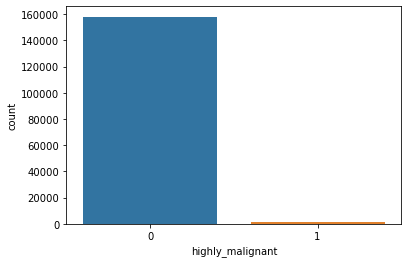

loathe
0    158166
1      1405
Name: loathe, dtype: int64


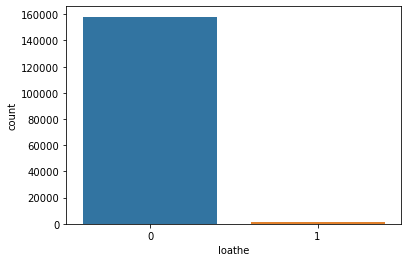

rude
0    151122
1      8449
Name: rude, dtype: int64


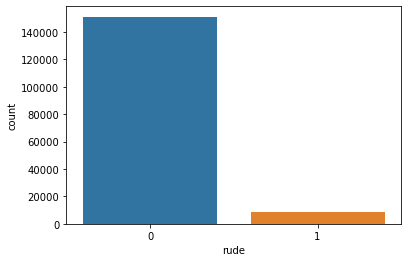

abuse
0    151694
1      7877
Name: abuse, dtype: int64


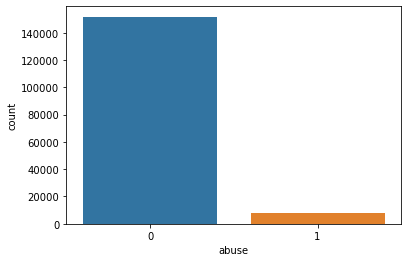

threat
0    159093
1       478
Name: threat, dtype: int64


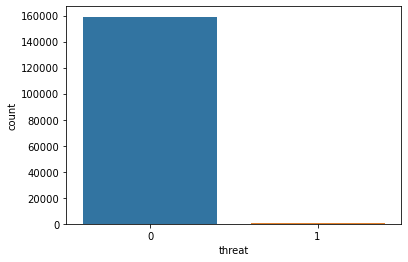

In [8]:
col =['malignant','highly_malignant','loathe','rude','abuse','threat']
for i in col:
    print(i)
    print(train_df[i].value_counts())
    sns.countplot(train_df[i])
    plt.show()

In [9]:
# Replace email addresses with 'email'
train_df['comment_text'] = train_df['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
train_df['comment_text'] = train_df['comment_text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
train_df['comment_text'] = train_df['comment_text'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
train_df['comment_text'] = train_df['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
   
# Replace numbers with 'number'
train_df['comment_text'] = train_df['comment_text'].str.replace(r'\d+(\.\d+)?', 'number')
# Remove punctuation
train_df['comment_text'] = train_df['comment_text'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
train_df['comment_text'] = train_df['comment_text'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
train_df['comment_text'] = train_df['comment_text'].str.replace(r'^\s+|\s+?$', '')

<ipython-input-9-e5a7f61a63c3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['comment_text'] = train_df['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')
<ipython-input-9-e5a7f61a63c3>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['comment_text'] = train_df['comment_text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')
<ipython-input-9-e5a7f61a63c3>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['comment_text'] = train_df['comment_text'].str.replace(r'£|\$', 'dollers')
<ipython-input-9-e5a7f61a63c3>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['comment_text'] = train_df['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
<ipython-input-9-e5a7f61a63c3>:14:

In [10]:
test_df['comment_text'] = test_df['comment_text'].str.replace(r'^\s+/\s+?$' , '')

<ipython-input-10-adbae32f092e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['comment_text'] = test_df['comment_text'].str.replace(r'^\s+/\s+?$' , '')


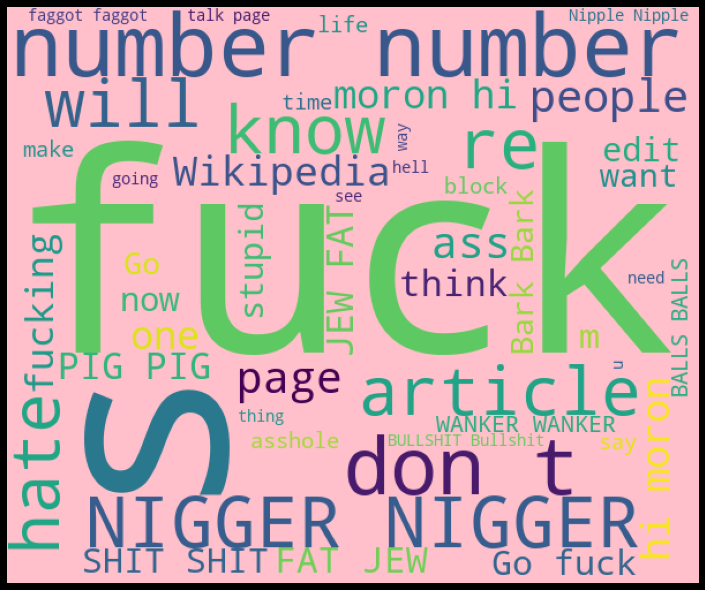

In [11]:
hams=train_df['comment_text'][train_df['malignant']==1]
spam_cloud=WordCloud(width=600, height=500, background_color='pink', max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
df_distribution=train_df[col].sum()\
                        .to_frame()\
                        .rename(columns={0:'count'})\
                        .sort_values('count')
df_distribution.plot.pie(y='count', 
                         title='Label distribution over comments',
                         figsize=(5,5))\
.legend(loc = 'center left', bbox_to_anchor = (1.3, 0.5))

In [13]:
lemmatizer=WordNetLemmatizer()
stemmer =PorterStemmer()

In [ ]:
for i in range(len(test_df['comment_text'])):
    test_df['comment_text'][i]=test_df['comment_text'][i].lower()
    j=[]
    for word in test_df['comment_text'][i].split():
        j.append(lemmatizer.lemmatize(word, pos='v'))
        test_df['comment_text'][i]=" ".join(j)
        

In [ ]:
for i in range(len(train_df['comment_text'])):
    train_df['comment_text'][i] = train_df['comment_text'][i].lower()
    j = []
    for word in train_df['comment_text'][i].split():
        j.append(lemmatizer.lemmatize(word, pos="v"))
        train_df['comment_text'][i] = "".join(j)

In [ ]:
x=train_df.drop(['malignant'],axis=1)
y=train_df['malignant']

In [ ]:
naive=MultinomialNB()

In [ ]:
tf_vec=TfidVectorizer()

In [ ]:
comment=train_df['comment_text']

In [ ]:
x=tf_vec.fit_transform(comment)

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(x,y,random_state=42)
naive.fit(x_train,y_train)

In [ ]:
y_pred=naive.predict(x_test)